In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import seaborn as sns
import  matplotlib.pyplot as plt
%matplotlib inline

In [2]:
orig_train=pd.read_csv('/Users/yybai/Desktop/house prices/train.csv')
orig_test=pd.read_csv('/Users/yybai/Desktop/house prices/test.csv')

In [3]:
def basic_explore():
    print('Train shape', orig_train.shape)
    print('Test shape', orig_test.shape)
    print('\n')
    ## number of nans for each col, ascendng
    print('Check number of nans for each col in train')
    print(orig_train.isnull().sum(axis=0).sort_values(ascending=False).head(25))
    print('Check number of nans for each col in test')
    print(orig_test.isnull().sum(axis=0).sort_values(ascending=False).head(25))
    print('\n')
    ## number of unique val for each col, ascending
    print('Check number of unique value for each col in train')
    print(orig_train.nunique(dropna=False).sort_values().head(20))
    print('\n')
    ## check target value
    stats=orig_train['SalePrice'].describe()
    print(stats)
basic_explore()

Train shape (1460, 81)
Test shape (1459, 80)


Check number of nans for each col in train
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
YearRemodAdd       0
MSSubClass         0
Foundation         0
ExterCond          0
ExterQual          0
dtype: int64
Check number of nans for each col in test
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2   

1. The features with so many nans should be deleted. 
2. It seems that pattern of missing values of features for train and test are basically similar. 
3. Sale price isright skewed.

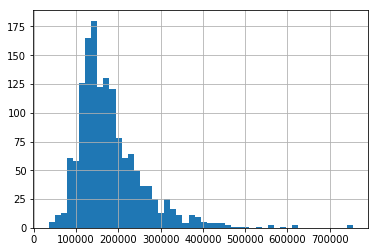

In [4]:
orig_train['SalePrice'].hist(bins = 50)    

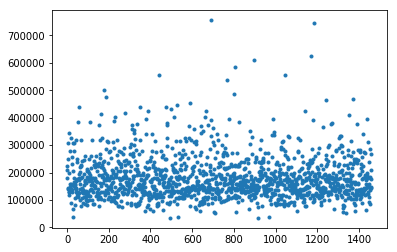

In [5]:
plt.plot(orig_train['SalePrice'],'.')

The data has been shuffled since there's no horizontal feature.

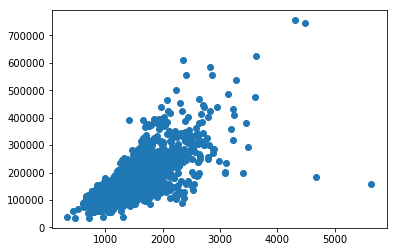

In [6]:
fig, ax = plt.subplots()
ax.scatter(x=orig_train['GrLivArea'],y=orig_train['SalePrice'])
plt.show()

GrLivArea is an important feature for prediction. Its outliers should be eliminated.

In [7]:
orig_train=orig_train.drop(orig_train[(orig_train['GrLivArea']>4000)&(orig_train['SalePrice']<300000)].index)

In [8]:
## change salesprice to log form, delete the first 4 vars with extremely large number of missings, also delete id
orig_train['SalePrice']=np.log1p(orig_train['SalePrice'])
X_train=orig_train.drop(columns=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Id','SalePrice'],axis=1)
Y_train=orig_train['SalePrice']
X_test=orig_test.drop(columns=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Id'])
traintest= pd.concat([X_train,X_test]).reset_index(drop=True)

In [9]:
print(traintest.shape,X_train.shape,Y_train.shape)

(2917, 74) (1458, 74) (1458,)


In [10]:
## find numerical/categorical features
cat=list(traintest.select_dtypes(include=['object']).columns)
num=list(traintest.select_dtypes(exclude=['object']).columns)
print("categorical:",cat,'\n','\n',"numerical:",num)
## MSSubClass and all time features should not be treated as numerical

categorical: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'] 
 
 numerical: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'Screen

In [11]:
## deal with missing values
traintest['Functional']=traintest['Functional'].fillna('Typ') 
traintest['Electrical']=traintest['Electrical'].fillna("SBrkr") 
traintest.update(traintest[cat].fillna('None'))
traintest.update(traintest[num].fillna(0))
traintest["LotFrontage"]=traintest.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
traintest['MSZoning']=traintest.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [12]:
traintest=traintest.drop(['Utilities', 'Street'], axis=1)

In [13]:
traintest['KitchenQual']=traintest['KitchenQual'].fillna(traintest['KitchenQual'].mode()[0])
traintest['Exterior2nd']=traintest['Exterior2nd'].fillna(traintest['Exterior2nd'].mode()[0])
traintest['SaleType']=traintest['SaleType'].fillna(traintest['SaleType'].mode()[0])

In [14]:
## check for skewness
from scipy.stats import norm, skew
skewed_feats=traintest[num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [15]:
skewness=skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features=skewness.index
lam=0.15
for feat in skewed_features:
    traintest[feat]=boxcox1p(traintest[feat],lam)

There are 36 skewed numerical features to Box Cox transform


In [16]:
## feature engineering
traintest['MSSubClass']=traintest['MSSubClass'].apply(str)
traintest['House_age_until_sold']=traintest['YrSold']-traintest['YearBuilt']
traintest['Year_Passed_Since_Remodel']=traintest['YrSold']-traintest['YearRemodAdd']
traintest['MoSold']=traintest['MoSold'].astype(str)
traintest['YearBuilt']=traintest['YearBuilt'].astype(str)
traintest['YearRemodAdd']=traintest['YearRemodAdd'].astype(str)
traintest['GarageYrBlt']=traintest['GarageYrBlt'].astype(str)

traintest['TotalSF']=traintest['TotalBsmtSF']+traintest['1stFlrSF']+traintest['2ndFlrSF']
traintest['Total_Bathrooms']=(traintest['FullBath']+(0.5*traintest['HalfBath'])\
                              +traintest['BsmtFullBath']+(0.5*traintest['BsmtHalfBath']))
traintest['Total_porch_sf']=(traintest['OpenPorchSF']+traintest['3SsnPorch']+traintest['EnclosedPorch']\
                              +traintest['ScreenPorch']+traintest['WoodDeckSF'])

In [17]:
traintest['haspool']=traintest['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
traintest['has2ndfloor']=traintest['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
traintest['hasgarage']=traintest['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
traintest['hasfireplace']=traintest['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [18]:
print(traintest.shape,X_train.shape,Y_train.shape)

(2917, 81) (1458, 74) (1458,)


In [19]:
final=pd.get_dummies(traintest).reset_index(drop=True)
X=final.iloc[:len(Y_train),:]
X_test=final.iloc[len(Y_train):, :]

Text(0.5, 1.0, 'Heatmap of all the Features in train with SalePrice')

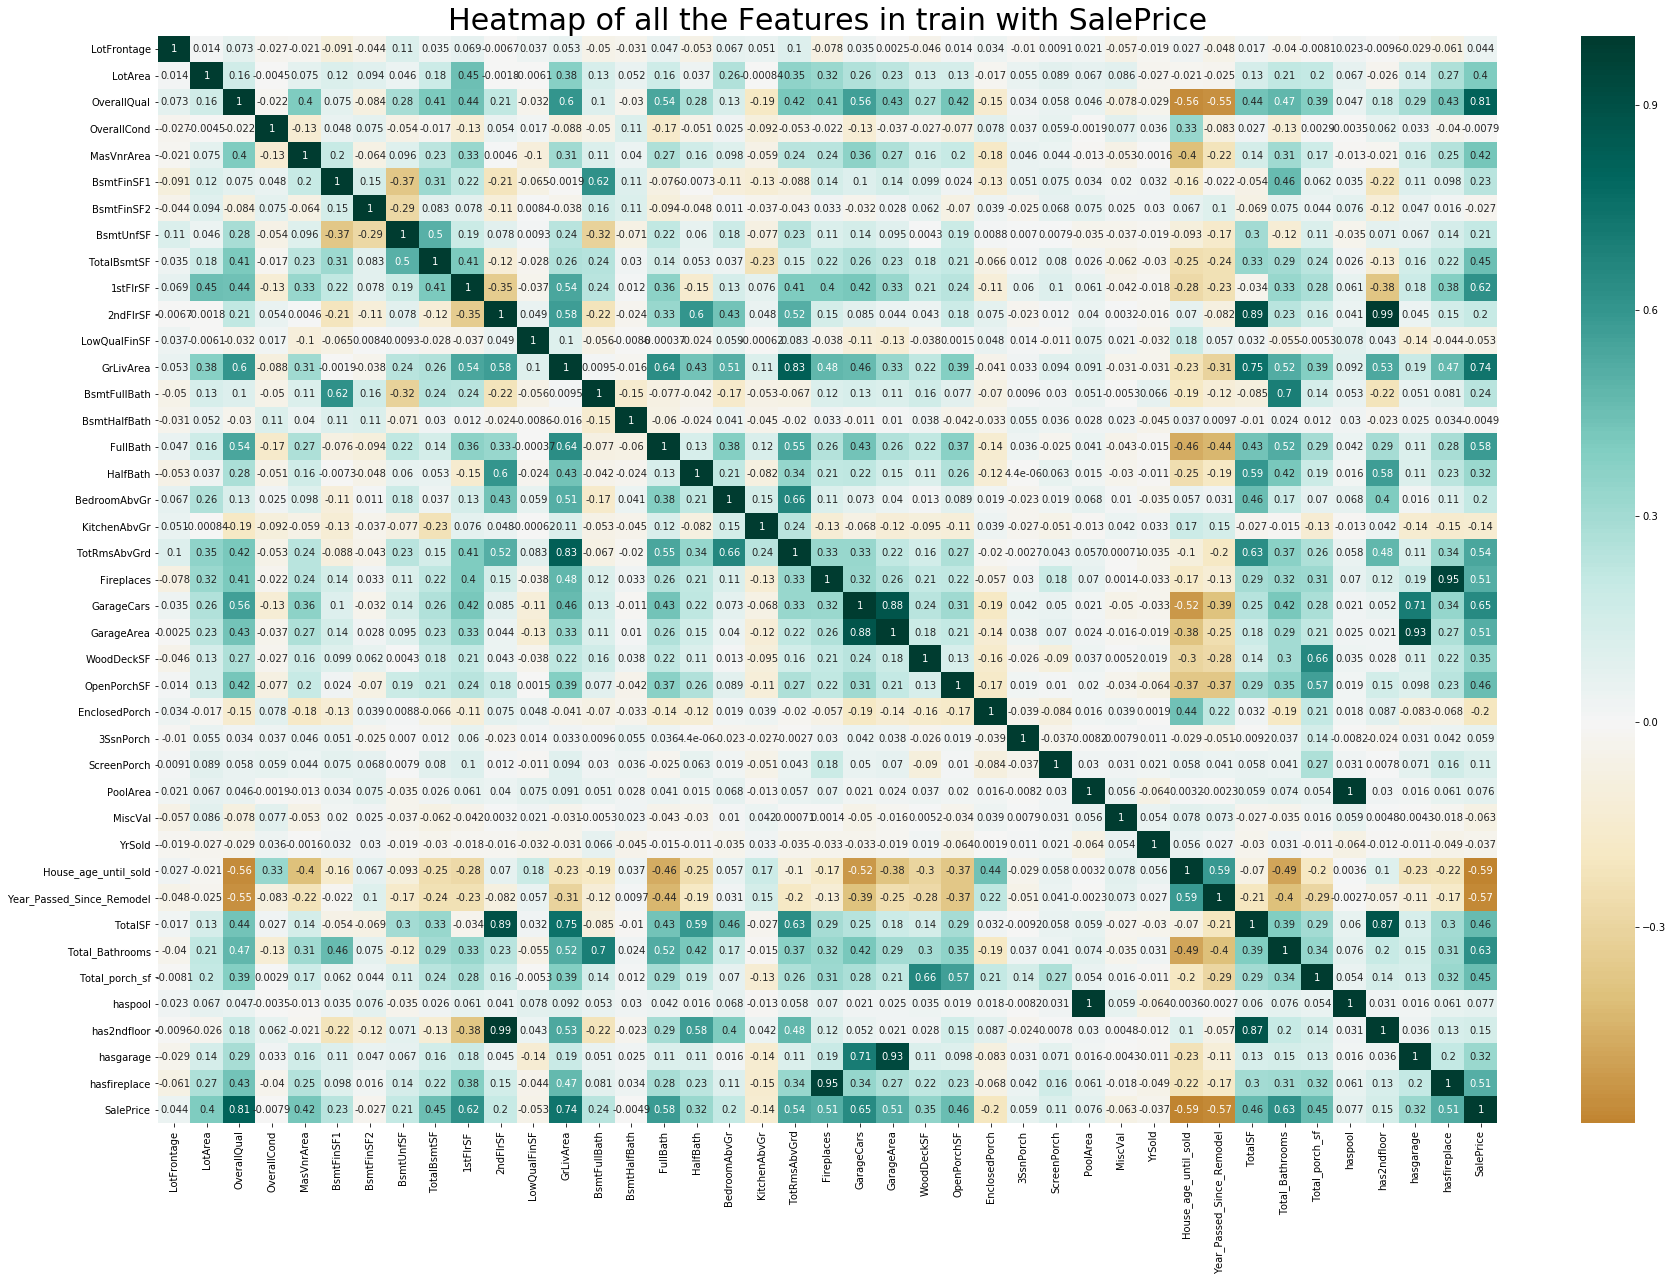

In [25]:
whole=pd.concat([traintest.iloc[:len(Y_train),:].reset_index(drop=True),Y_train.reset_index(drop=True)],axis= 1)
plt.subplots(figsize = (30,20))
sns.heatmap(whole.corr(), cmap="BrBG", annot=True, center = 0)
plt.title("Heatmap of all the Features in train with SalePrice", fontsize = 30)

Text(0.5, 1.0, 'Heatmap of all the Features in train and test')

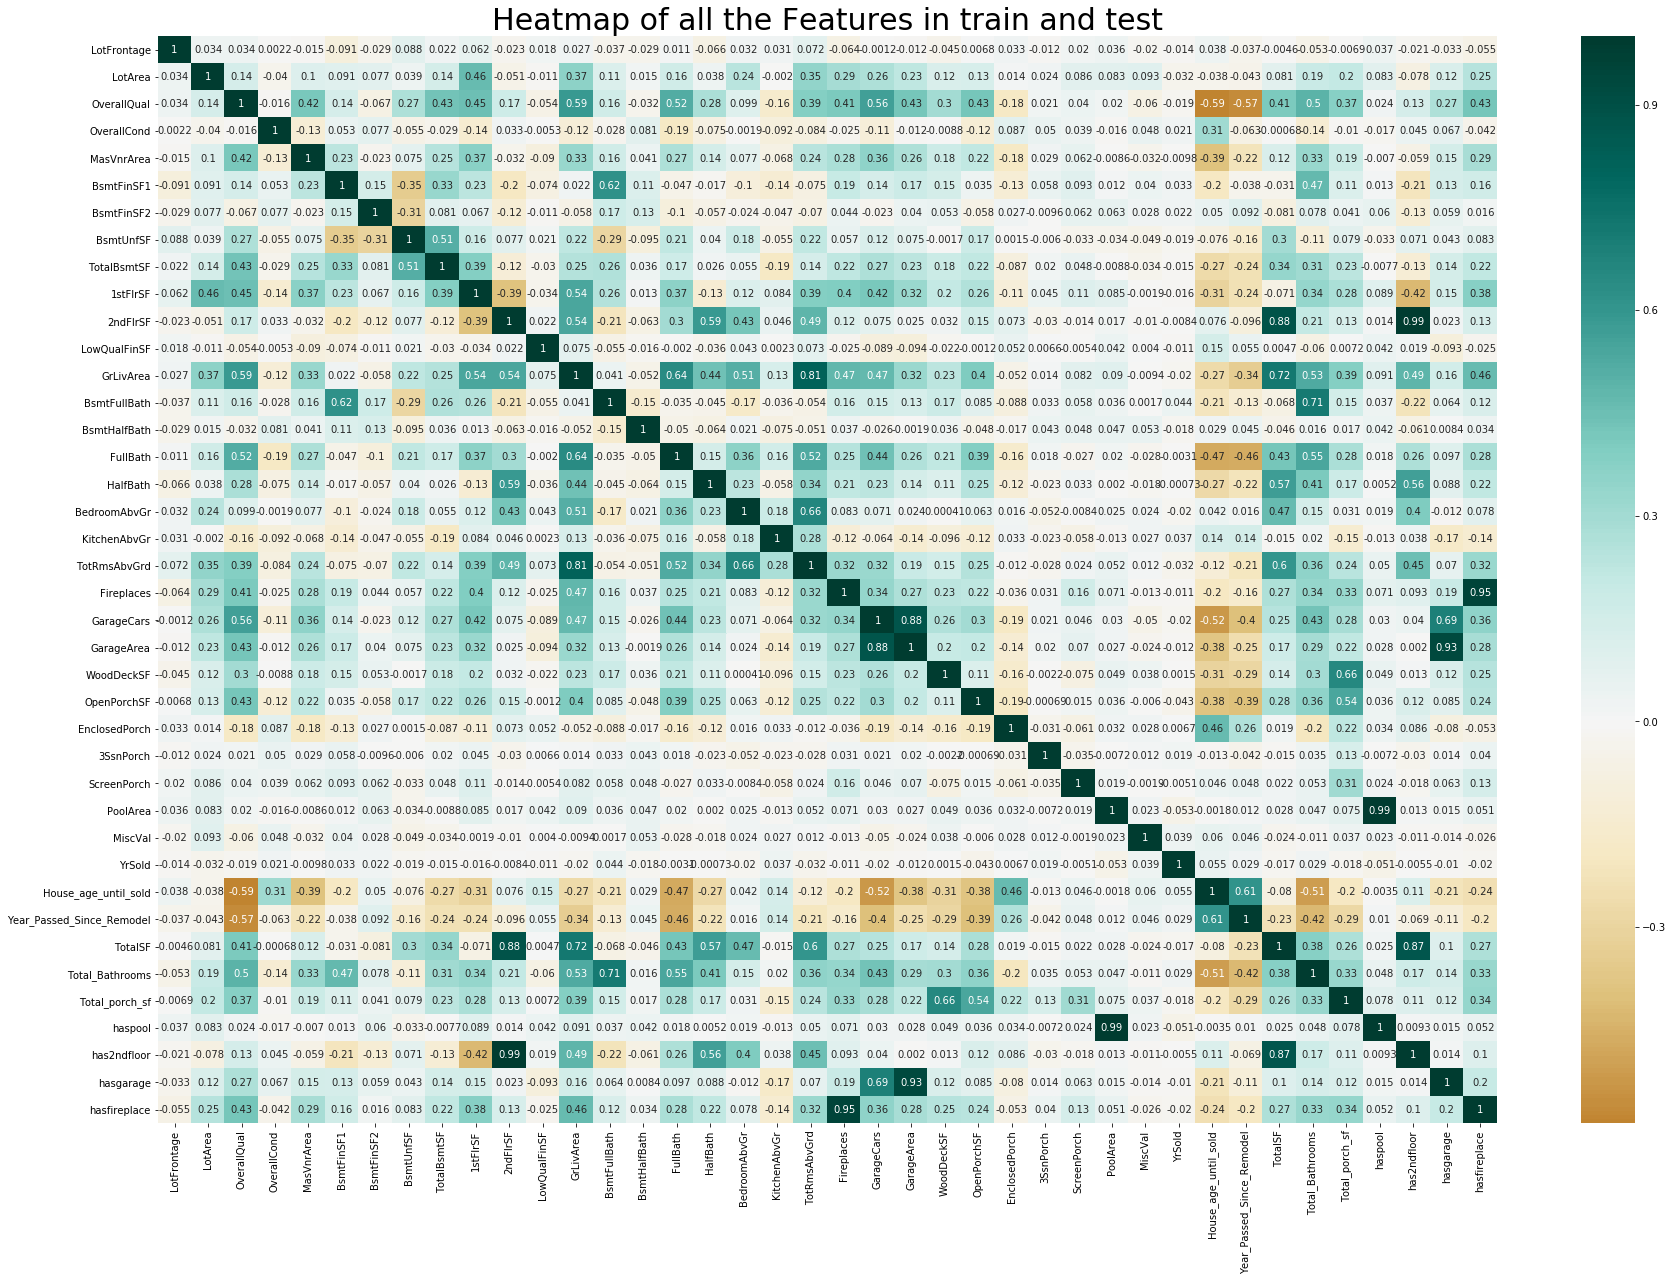

In [26]:
plt.subplots(figsize = (30,20))
sns.heatmap(traintest.corr(), cmap="BrBG", annot=True, center = 0)
plt.title("Heatmap of all the Features in train and test", fontsize = 30)

From the above charts, SalePrice is correlated with OverallQual(0.81),GrLivArea(0.74),GarageCars(0.65),TotalBathroom(0.63),1stFlrSF(0.62),House age until sold(-0.59), FullBath(0.58),Year passed since remodel(-0.57).

Also, notice that the data distribution for all numerical features in test and train are generally similar, since heatmap of feature coorelation within train and within traintest share extremely similar pattern.

In [27]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

/Users/yybai/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [28]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, Y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [29]:
model_xgb=xgb.XGBRegressor(learning_rate=0.01,n_estimators=3400,max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,colsample_bytree=0.7,objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,reg_alpha=0.00006)

In [ ]:
score=cv_rmse(model_xgb)

In [31]:
model_xgb.fit(X,Y_train)

/Users/yybai/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/yybai/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=0, missing=None, n_estimators=3400, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=6e-05,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.7)

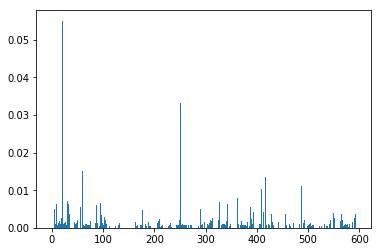

In [32]:
plt.bar(range(len(model_xgb.feature_importances_)), model_xgb.feature_importances_)
plt.show()

In [33]:
## select only ones with importance > 0.001
from sklearn.feature_selection import SelectFromModel 
selection=SelectFromModel(model_xgb,threshold=0.0001, prefit=True)
select_X_train=selection.transform(X)
select_X_test=selection.transform(X_test)

In [ ]:
score_trans=cv_rmse(model_xgb, X=select_X_train)
## output warning removed

In [35]:
score_trans.mean(),score_trans.std()

(0.11297677882578414, 0.014394480814177739)

In [37]:
model_lgbm=lgb.LGBMRegressor(objective='regression',num_leaves=4,learning_rate=0.01,n_estimators=5000,max_bin=200, 
                                       bagging_fraction=0.75,bagging_freq=5,bagging_seed=7,feature_fraction=0.2,
                                       feature_fraction_seed=7,verbose=-1)
model_gbr=GradientBoostingRegressor(n_estimators=3000,learning_rate=0.01,max_depth=4,max_features='sqrt',\
                                min_samples_leaf=15,min_samples_split=10,loss='huber')  
model_rf=RandomForestRegressor(n_estimators=4000,min_samples_split=5)

params_ridge=[5,10,15]
params=[0.00005,0.0001,0.0005,0.001,0.005,0.01]
model_ridge=make_pipeline(RobustScaler(), RidgeCV(alphas=params_ridge,cv=kfolds))
model_lasso=make_pipeline(RobustScaler(), LassoCV(alphas=params,cv=kfolds))
model_enet=make_pipeline(RobustScaler(), ElasticNetCV(alphas=params,l1_ratio=0.9,cv=kfolds)) 

In [ ]:
score_ridge=cv_rmse(model_ridge,X=select_X_train)
score_lasso=cv_rmse(model_lasso,X=select_X_train)
score_enet=cv_rmse(model_enet,X=select_X_train)
score_lgbm=cv_rmse(model_lgbm,X=select_X_train)
score_gbr=cv_rmse(model_gbr,X=select_X_train)
## output warning removed

In [39]:
print("Ridge: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))
print("Lasso: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))
print("ElasticNet: {:.4f} ({:.4f})\n".format(score_enet.mean(), score_enet.std()))
print("Lightgbm: {:.4f} ({:.4f})\n".format(score_lgbm.mean(), score_lgbm.std()))
print("gbr: {:.4f} ({:.4f})\n".format(score_gbr.mean(), score_gbr.std()))
print("xgboost: {:.4f} ({:.4f})\n".format(score_trans.mean(), score_trans.std()))

Ridge: 0.1107 (0.0160)

Lasso: 0.1097 (0.0158)

ElasticNet: 0.1100 (0.0158)

Lightgbm: 0.1137 (0.0155)

gbr: 0.1129 (0.0140)

xgboost: 0.1130 (0.0144)



RandomForest Regressor has also been tried, but its error is much higher than others.

In [ ]:
model_ridge.fit(select_X_train,Y_train)
model_lasso.fit(select_X_train,Y_train)
model_enet.fit(select_X_train,Y_train)
model_lgbm.fit(select_X_train,Y_train)
model_gbr.fit(select_X_train,Y_train)
model_xgb.fit(select_X_train,Y_train)
## output warning removed

In [40]:
from mlxtend.regressor import StackingCVRegressor
stacking=StackingCVRegressor(regressors=(model_ridge,model_lasso,model_enet,model_lgbm,model_gbr,model_xgb),
                                meta_regressor=model_xgb,
                                use_features_in_secondary=True)

In [ ]:
model_stack_gen=stacking.fit(select_X_train, np.array(Y_train))
## output warning removed

In [52]:
def blend(X):
    return ((0.1 * model_enet.predict(X)) + \
            (0.2 * model_lasso.predict(X)) + \
            (0.1 * model_ridge.predict(X)) + \
            (0.05 * model_gbr.predict(X)) + \
            (0.05 * model_xgb.predict(X)) + \
            (0.05 * model_lgbm.predict(X)) + \
            (0.45 * model_stack_gen.predict(X)))

In [53]:
Y_pred=stacking.predict(select_X_train)
print(rmse(Y_train,Y_pred))

0.04889251215348508


In [54]:
Y_pred=blend(select_X_train)
print(rmse(Y_train,Y_pred))

0.06570525011073439


In [56]:
submission=pd.read_csv("/Users/yybai/Desktop/house prices/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend(select_X_test)))

In [57]:
submission.head()

,Id,SalePrice
0,1461,120866.0
1,1462,154532.0
2,1463,182335.0
3,1464,197585.0
4,1465,188752.0


In [58]:
submission.to_csv('/Users/yybai/Desktop/house prices/sub.csv',index=False)